In [10]:
from fastapi import FastAPI, File, UploadFile
import nest_asyncio
from tensorflow.keras.models import load_model
from fastapi.testclient import TestClient
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from PIL import Image
import numpy as np
import cv2
import io
import uvicorn
import matplotlib.pyplot as plt

In [11]:
model = load_model("my_keras_model.keras")

In [12]:
def pad_to_9_16_ratio(image):
    # Get the current dimensions of the image
    height, width = image.shape[:2]
    
    # Calculate the target aspect ratio (9:16)
    target_ratio = 9 / 16
    
    # Calculate the current aspect ratio of the image
    current_ratio = width / height
    
    if current_ratio > target_ratio:
        # If the image is too wide for 9:16 ratio, Calculate new height to match 9:16 ratio while keeping the current width
        new_height = int(width / target_ratio)
        new_width = width
        
        # Calculate padding for top and bottom
        pad_top = (new_height - height) // 2
        pad_bottom = new_height - height - pad_top
        
        # No padding needed for left and right
        pad_left = 0
        pad_right = 0
    else:
        # If the image is too tall for 9:16 ratio, Calculate new width to match 9:16 ratio while keeping the current height
        new_width = int(height * target_ratio)
        new_height = height
        
        # Calculate padding for left and right
        pad_left = (new_width - width) // 2
        pad_right = new_width - width - pad_left
        
        # No padding needed for top and bottom
        pad_top = 0
        pad_bottom = 0
        
    padded_image = cv2.copyMakeBorder(
        image,
        pad_top,
        pad_bottom,
        pad_left,
        pad_right,
        cv2.BORDER_CONSTANT,  # Use constant value for padding
        value=[0, 0, 0]  # Black color in BGR format
    )
    
    return padded_image

# Example usage:
# image = cv2.imread('path_to_your_image.jpg')
# padded_image = pad_to_9_16_ratio(image)
# cv2.imwrite('padded_image.jpg', padded_image)

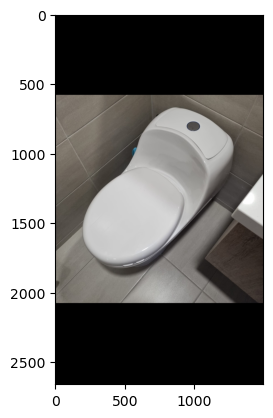

In [7]:
image = cv2.imread("C:/Users/jacob\OneDrive/Summer III/Test images/Juan_image.jpg")
padded_image = pad_to_9_16_ratio(image)
cv2.imwrite('padded_image.jpg', padded_image)
plt.imshow(cv2.cvtColor(padded_image, cv2.COLOR_BGR2RGB))

In [ ]:
# Convert images from BGR to RGB for display
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
padded_image_rgb = cv2.cvtColor(padded_image, cv2.COLOR_BGR2RGB)

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Display original image
ax1.imshow(image_rgb)
ax1.set_title('Original Image')
ax1.axis('off')

# Display padded image
ax2.imshow(padded_image_rgb)
ax2.set_title('Padded Image (9:16 ratio)')
ax2.axis('off')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [4]:
# Apply nest_asyncio to allow asyncio to run in Jupyter
nest_asyncio.apply()

In [5]:
def predict_image(image_path, model):
    # Load and preprocess the image
    img = cv2.imread(image_path)
    
    # Pad the image to 9:16 ratio
    padded_img = pad_to_9_16_ratio(img)
    
    # Resize the padded image to match your model's input shape
    resized_img = cv2.resize(padded_img, (288, 512))  # Adjust size to match your model's input shape
    
    # Convert BGR to RGB (if your model expects RGB input)
    rgb_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
    
    # Convert to float32 and normalize
    img_array = rgb_img.astype(np.float32) / 255.0
    
    # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)
    
    # Make prediction
    predictions = model.predict(img_array)
    predicted_class = "Faucet" if predictions[0][0] > 0.5 else "Toilet"
    confidence = float(max(predictions[0]))
    
    return {"class": predicted_class, "confidence": confidence}

# Test the model with your image
test_image_path = r"C:\Users\jacob\OneDrive\Summer III\Test images\IMG_2804.jpg"
result = predict_image(r"C:\Users\jacob\OneDrive\Summer III\Test images\IMG_2804.jpg", model)
print(result)

1/1 [==============================] - 0s 309ms/step
{'class': 'Toilet', 'confidence': 0.9999953508377075}


In [13]:
app = FastAPI()

In [5]:
#pip install python-multipart

Note: you may need to restart the kernel to use updated packages.


In [6]:
@app.get('/')
def index():
    return {'message': 'Toilet vs Faucet ML API'}

@app.post("/predict/")
async def predict(file: UploadFile = File(...)):
    # 1. VALIDATE INPUT FILE
    filename = file.filename
    fileExtension = filename.split(".")[-1] in ("jpg", "jpeg", "png")
    if not fileExtension:
        raise HTTPException(status_code=415, detail="Unsupported file provided.")
    
    # 2. TRANSFORM RAW IMAGE INTO CV2 image
    image_stream = io.BytesIO(await file.read())
    image_stream.seek(0)
    file_bytes = np.asarray(bytearray(image_stream.read()), dtype=np.uint8)
    image = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)
    
    # 3. PAD THE IMAGE
    padded_image = pad_to_9_16_ratio(image)
    
    # 4. RESIZE THE PADDED IMAGE
    resized_image = cv2.resize(padded_image, (288, 512))
    
    # 5. PREPROCESS THE IMAGE
    rgb_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
    image_array = img_to_array(rgb_image)
    image_array = np.expand_dims(image_array, axis=0)
    image_array = image_array.astype(np.float32) / 255.0
    
    # 6. MAKE PREDICTION
    predictions = model.predict(image_array)
    
    # Define class labels
    CLASS_LABELS = {0: "Faucet", 1: "Toilet"}
    
    # 7. INTERPRET THE PREDICTION
    predicted_index = int(predictions[0][0] > 0.5)
    predicted_class = CLASS_LABELS[predicted_index]
    confidence = float(predictions[0][predicted_index])

    print("Raw predictions:", predictions)
    
    # 8. RETURN THE PREDICTION RESULT
    return {"class": predicted_class, "confidence": confidence}

In [14]:
@app.get('/')
def index():
    return {'message': 'Toilet vs Faucet ML API'}

@app.post("/predict/")
async def predict(file: UploadFile = File(...)):
    # 1. VALIDATE INPUT FILE
    filename = file.filename
    fileExtension = filename.split(".")[-1] in ("jpg", "jpeg", "png")
    if not fileExtension:
        raise HTTPException(status_code=415, detail="Unsupported file provided.")
    
    # 2. TRANSFORM RAW IMAGE INTO CV2 image
    image_stream = io.BytesIO(await file.read())
    image_stream.seek(0)
    file_bytes = np.asarray(bytearray(image_stream.read()), dtype=np.uint8)
    image = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)
    
    # 3. PAD THE IMAGE
    padded_image = pad_to_9_16_ratio(image)
    
    # 4. RESIZE THE PADDED IMAGE
    resized_image = cv2.resize(padded_image, (288, 512))
    
    # 5. PREPROCESS THE IMAGE
    rgb_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
    image_array = img_to_array(rgb_image)
    image_array = np.expand_dims(image_array, axis=0)
    image_array = image_array.astype(np.float32) / 255.0
    
    # 6. MAKE PREDICTION
    predictions = model.predict(image_array)
    
    # Define class labels
    CLASS_LABELS = {0: "Faucet", 1: "Toilet"}
    
    # 7. INTERPRET THE PREDICTION
    predicted_index = int(predictions[0][0] > 0.5)
    predicted_class = CLASS_LABELS[predicted_index]
    confidence = float(predictions[0][predicted_index])
    
    # 8. RETURN THE PREDICTION RESULT
    return {"Raw predictions:", predictions}

In [9]:
@app.get('/')
def index():
    return {'message': 'Toilet vs Faucet ML API'}

# Define the prediction endpoint
@app.post("/predict/")
def predict(file: UploadFile = File(...)):
    # Read the contents of the uploaded file
     # 1. VALIDATE INPUT FILE
    filename = file.filename
    fileExtension = filename.split(".")[-1] in ("jpg", "jpeg", "png")
    if not fileExtension:
        raise HTTPException(status_code=415, detail="Unsupported file provided.")
    
    # 2. TRANSFORM RAW IMAGE INTO CV2 image
    
    # Read image as a stream of bytes
    image_stream = io.BytesIO(file.file.read())
    
    # Start the stream from the beginning (position zero)
    image_stream.seek(0)
    
    # Write the stream of bytes into a numpy array
    file_bytes = np.asarray(bytearray(image_stream.read()), dtype=np.uint8)
    
    # Decode the numpy array as an image
    image = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)


    # Preprocess the image
    image = image.resize((512, 288))  # Resize image to match model's expected input size
    image_array = img_to_array(image)  # Convert image to numpy array
    image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension
    image_array = image_array / 255.0  # Normalize pixel values to range [0, 1]

    # Make prediction using the loaded model
    predictions = model.predict(image_array)
    
   # Define class labels
    CLASS_LABELS = {0: "Faucet", 1: "Toilet"}  
    predicted_index = int(predictions[0][0] > 0.5)  
    predicted_class = CLASS_LABELS[predicted_index]
    confidence = float(predictions[0][predicted_index])  # Get the confidence of the prediction

    # Return the prediction result as a JSON response
    return {"class": predicted_class, "confidence": confidence}

In [6]:
client = TestClient(app)

In [15]:
# Function to run the app
def run_app():
    uvicorn.run(app, host="127.0.0.1", port=8000)

In [16]:
# Run this in a notebook cell to start the server
print("Server is starting. Visit http://127.0.0.1:8000 in your browser.")
run_app()

Server is starting. Visit http://127.0.0.1:8000 in your browser.


INFO:     Started server process [31788]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


INFO:     127.0.0.1:62288 - "GET / HTTP/1.1" 200 OK
INFO:     127.0.0.1:62288 - "GET /docs HTTP/1.1" 200 OK
INFO:     127.0.0.1:62288 - "GET /openapi.json HTTP/1.1" 200 OK
1/1 [==============================] - 0s 168ms/step
INFO:     127.0.0.1:62289 - "POST /predict/ HTTP/1.1" 500 Internal Server Error


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "C:\Users\jacob\anaconda3\lib\site-packages\uvicorn\protocols\http\h11_impl.py", line 407, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
  File "C:\Users\jacob\anaconda3\lib\site-packages\uvicorn\middleware\proxy_headers.py", line 78, in __call__
    return await self.app(scope, receive, send)
  File "C:\Users\jacob\anaconda3\lib\site-packages\fastapi\applications.py", line 292, in __call__
    await super().__call__(scope, receive, send)
  File "C:\Users\jacob\anaconda3\lib\site-packages\starlette\applications.py", line 122, in __call__
    await self.middleware_stack(scope, receive, send)
  File "C:\Users\jacob\anaconda3\lib\site-packages\starlette\middleware\errors.py", line 184, in __call__
    raise exc
  File "C:\Users\jacob\anaconda3\lib\site-packages\starlette\middleware\errors.py", line 162, in __call__
    await self.app(scope, receive, _send)
  File "C:\Users\jacob\ana

In [21]:
# Test the model with your image
test_image_path = r"C:\Users\jacob\OneDrive\Summer III\Test images\IMG_2790.jpg"
with open(test_image_path, "rb") as image_file:
    response = client.post("/predict/", files={"file": ("IMG_2790.jpg", image_file, "image/jpeg")})

print(response.json())

{'detail': 'There was an error parsing the body'}
